In [1]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def generate_face(num_points, noise_factor=0.01):
    '''
    Input: an amount of points to generate and a noise factor that controls how much the points are scattered
    Output: a numpy array containing the coordinates of the points in the pattern of a smiley face
    '''
    #generating the points: the components of the face are scaled with a certain factor and shifted
    face_circle = np.array([[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, num_points)])[:-1].copy()
    left_eye = np.array([[0.2 * np.cos(theta) - 0.37, 0.2 * np.sin(theta) + 0.2] for theta in np.linspace(0, 2 * np.pi, num_points)])[:-1].copy()
    right_eye = np.array([[0.2 * np.cos(theta) + 0.37, 0.2 * np.sin(theta) + 0.2] for theta in np.linspace(0, 2 * np.pi, num_points)])[:-1].copy()
    smile = np.array([[0.8 * np.cos(theta), 0.4 * np.sin(theta) - 0.8] for theta in np.linspace(0.4 * np.pi, 0.6 * np.pi, num_points)])
    
    #adding noise
    noise = np.random.normal(scale=noise_factor, size=(len(face_circle), 2))
    face_circle += noise
    noise = np.random.normal(scale=noise_factor, size=(len(left_eye), 2))
    left_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(right_eye), 2))
    right_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(smile), 2))
    smile += noise
    
    #merges numpy arrays
    return np.concatenate([face_circle, left_eye, right_eye, smile])


def generate_spiral(num_points, xtranslation=0, ytranslation=0, turns=2, scale= 0.08, noise_factor=0.01):
    '''
    Input: an amount of points to generate, the x and y traslation, the number of turns and the scale of the spiral and a noise factor that controls how much the points are scattered
    Output: a numpy array containing the coordinates of the points in the pattern of a spiral
    '''
    #the spiral is scaled by a certain factor
    theta = np.linspace(0, 2 * np.pi * turns, num_points)
    radius = theta
    x = radius * np.cos(theta) * scale
    y = radius * np.sin(theta) * scale

    #adding noise
    noise = np.random.normal(scale=noise_factor, size=(len(x), 2))
    x += noise[:, 0]
    y += noise[:, 1]

    #adding translation
    x+=xtranslation
    y+=ytranslation

    spiral_points = np.column_stack((x, y))

    return spiral_points


def merge_spirals(spiralA, spiralB, degrees=0):
    '''
    Input: two numpy arrays of points shaped like a spiral and a rotation angle
    Output: a numpy array containing the coordinates of the points in the pattern of a double spiral
    '''

    def rotate_points(points, angle_degrees):
        '''
        Helper function for merge_spiral
        Input: a numpy array of point coordinates and a rotation angle
        Output: the rotated numpy array of points  
        '''
        points_array = np.array(points)
        angle_radians = np.radians(angle_degrees)
        rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])
        rotated_points_array = np.dot(points_array, rotation_matrix.T)
        return rotated_points_array

    #merges two spirals adding a rotation to one of them
    rotated_spiral = rotate_points(spiralB, degrees)
    merged_spiral = np.concatenate((rotated_spiral, spiralA))

    return merged_spiral


def generate_doughnut(outer_radius, num_outer_points, outer_noise_level, inner_radius, num_inner_points,  inner_noise_level):
    '''
    Input: the radius of an outer circle, an amount of points to generate for the outer circle, a noise factor that controls how much the outer circle points are scattered, 
           the radius of an inner circle, an amount of points to generate for the inner circle, a noise factor that controls how much the inner circle points are scattered
    Output: a numpy array containing the coordinates of the points in the pattern of a doughnut
    '''
    angles = np.linspace(0, 2*np.pi, num_outer_points)
    xo = outer_radius * np.cos(angles)
    yo = outer_radius * np.sin(angles)

    angles = np.linspace(0, 2*np.pi, num_inner_points)
    xi = inner_radius * np.cos(angles)
    yi = inner_radius * np.sin(angles)

    #add random noise to the points
    xo += outer_noise_level * np.random.randn(num_outer_points)
    yo += outer_noise_level * np.random.randn(num_outer_points)

    xi += inner_noise_level * np.random.randn(num_inner_points)
    yi += inner_noise_level * np.random.randn(num_inner_points)

    #clip the points in range [-1;1] for dataset uniformity 
    xo = np.clip(xo, -1, 1)
    yo = np.clip(yo, -1, 1)

    xi = np.clip(xi, -1, 1)
    yi = np.clip(yi, -1, 1)

    #combine x and y into a 2D array
    circular_outer_points = np.column_stack((xo, yo))  
    circular_inner_points = np.column_stack((xi, yi))

    #merges numpy arrays
    combined_circular_points = np.concatenate((circular_outer_points, circular_inner_points))
    
    return combined_circular_points


def generate_barred_spiral(num_points, radius, noise_factor, xTranslation, yTranslation):
    '''
    Input: an amount of points to generate, the radius of the barred spiral, a noise factor that controls how much the points are scattered and an x and y translation 
           to move the bottom half of the barred spiral
    Output: a numpy array containing the coordinates of the points in the pattern of a barred spiral
    '''
    theta = np.linspace(0, np.pi, num_points)
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)

    x2 = radius * np.cos(theta)
    y2 = radius * np.sin(theta)

    #add random noise
    noise_x1 = noise_factor * np.random.randn(num_points)
    noise_y1 = noise_factor * np.random.randn(num_points)
    noise_x2 = noise_factor * np.random.randn(num_points)
    noise_y2 = noise_factor * np.random.randn(num_points)

    x1 += noise_x1
    y1 += noise_y1

    x2 += noise_x2
    y2 += noise_y2

    #translate on the x and y axis the bottom half of the barred spiral
    x2 += xTranslation
    y2 += yTranslation


    #clip the points in range [-1;1] for dataset uniformity 
    x1 = np.clip(x1, -1, 1)
    y1 = np.clip(y1, -1, 1)
    x2 = np.clip(x2, -1, 1)
    y2 = np.clip(y2, -1, 1)

    half_barred_spiral1 = np.column_stack((x1, y1))
    half_barred_spiral2 = np.column_stack((x2, y2))

    #flip the bottom half of the barred spiral on x-axis
    half_barred_spiral2[:, 1] *= -1

    #merges numpy arrays
    combined_barred_spiral_points = np.concatenate((half_barred_spiral1, half_barred_spiral2))

    return combined_barred_spiral_points


def mix_fixed_points():
    '''
    Input: there is no input required because this is a data set with fixed points coordinates
    Output: a numpy array containing the coordinates of the points in the pattern of the vertices of some squares and rectangles
    '''

    fixed_2d_points = np.array([
    [1.0, 1.0],
    [1.0, 1.5],
    [1.5, 1.0],
    [1.5, 1.5],
    [1.0, 3.0],
    [1.5, 3.0],
    [1.0, 2.5],
    [1.5, 2.5],
    [7.0, 7.0],
    [7.0, 7.5],
    [7.5, 7.0],
    [7.5, 7.5],
    [5.0, 5.0],
    [5.0, 5.5],
    [5.5, 5.0],
    [5.5, 5.5],
    [4.0, 2.0],
    [4.0, 2.5],
    [4.5, 2.0],
    [4.5, 2.5],
    [5.0, 2.5],
    [5.0, 2.0],
    [6.0, 2.5],
    [6.0, 2.0],
    [5.5, 2.0],
    [6.5, 2.5],
    [5.5, 2.5],
    [6.5, 2.0],
    [2.0, 5.0],
    [2.0, 5.5],
    [2.5, 5.0],
    [2.5, 5.5],
    [2.0, 6.0],
    [2.5, 6.0],
    [2.0, 6.5],
    [2.5, 6.5],
    [2.0, 7.0],
    [2.5, 7.0]
    ])

    #normalizes points in a numpy array in the range [-1,1]
    x_values, y_values = zip(*fixed_2d_points)

    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)

    normalized_x = [(x - x_min) / (x_max - x_min) * 2 - 1 for x in x_values]
    normalized_y = [(y - y_min) / (y_max - y_min) * 2 - 1 for y in y_values]
    
    normalized_points = np.array(list(zip(normalized_x, normalized_y)))
    
    return normalized_points

In [6]:
def plot_points(points, title='Point dataset'):
    '''
    Input: a numpy array of point coordinates
    Output: a scatter plot of the points
    '''
    plt.scatter(points[:, 0], points[:, 1], s=5, c='blue')
    plt.axis('equal')
    plt.title(title)
    plt.show()

def delaunay_triangulation(points):
    '''
    Input: a numpy array of point coordinates
    Output: a Delaunay triangulation plot
    '''
    tri = Delaunay(points)
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    plt.axis('equal')
    plt.title('Delaunay Graph')
    plt.show()

def rdg_compute(points, threshold=1.8):
    '''
    Input: a numpy array of point coordinates and a threshold: the threshold can be either a positive number or a string ("mean" or "area"):
        if it's a positive number, it's used as a static threshold for the values in the map
        if it's "mean", a dynamic threshold is computed based on the mean of the values in the map
        if it's "area", a dynamic threshold is computed based on the area of the smallest enclosing circle of all the points
    Output: a Reduced Delaunay Graph plot
    '''
    if not isinstance(threshold, str):
        if threshold <= 0:
            print("Threshold has to be positive")
            return
    
    tri = Delaunay(points)
    result_edge_map = {}

    def min_distance_between_neighbors(point, points, tri, i):
        '''
        Helper function for rdg_compute
        Input: a point, a numpy array of point coordinates, a Delaunay triangulation and the index of the point
        Output: the minimum distance between the point and its neighbors, the neighbors themselves and all the distances between the point and the neighbors
        '''
        #find the indices of neighboring vertices for the current point
        simplex_indices = np.where(np.any(tri.simplices == i, axis=1))[0]
        neighbor_indices = np.unique(tri.simplices[simplex_indices])
        neighbors = points[neighbor_indices]

        #calculate distances between the  vertices and return the minimum between them
        distances = np.linalg.norm(neighbors - point, axis=1)
        return np.min(distances[distances > 0]), neighbors, distances

    #looping through all the points, calculate a value for each edge (geometric average between two distance ratios) and store it in a map
    for i, point in enumerate(points):
        #calculate the minimum distance between the current point and its neighbors
        min_distance1, neighbors, distances = min_distance_between_neighbors(point, points, tri, i)

        for neighbor, distance in zip(neighbors, distances):
            if distance > 0:
                #first ratio: distance between the current point and its neighbor divided by the minimum distance between the current point and its neighbors
                ratio1 = distance / min_distance1

                #second ratio: distance between the current point and its neighbor divided by the minimum distance between the neighbor and its neighbors
                min_distance2, _, _ = min_distance_between_neighbors(neighbor, points, tri, i)
                ratio2 = distance / min_distance2

                #geometric average between the two ratios
                result = np.sqrt(ratio1 * ratio2)

                #store the result in a map with the associated edge as the key
                edge = tuple(sorted((tuple(point), tuple(neighbor)), key=lambda x: (x[0], x[1])))
                result_edge_map[edge] = result

    if(isinstance(threshold, str)):
        if threshold == "mean":
            #dynamic threshold calculation based on the mean of the values in the map
            total_sum = 0
            count = 0
            for value in result_edge_map.values():
                if isinstance(value, (int, float)):
                    total_sum += value
                    count += 1
            thresholdDynamic = (total_sum / count) - 1 / (total_sum / count)
        elif threshold == "area":
            #dynamic threshold calculation based on the area of the smallest enclosing circle of all the points
            def minimum_enclosing_circle_area(points):
                '''
                Helper function for rdg_compute
                Input: a numpy array of point coordinates
                Output: the area of the minimum enclosing circle of the points
                '''
                hull = ConvexHull(points)
                center = np.mean(points[hull.vertices], axis=0)
                radius = np.max(np.linalg.norm(points[hull.vertices] - center, axis=1))
                area = np.pi * radius**2
                return area
            min_area = minimum_enclosing_circle_area(points)
            thresholdDynamic = min_area*0.5
        else:
            print("Invalid threshold: please pass a positive number or 'mean' or 'area'")
            return
        print(f"Dynamic computed threshold based on {threshold}: {thresholdDynamic}")
    else:
        #static threshold passed as function parameter
        thresholdDynamic = threshold
        print(f"Threshold passed: {thresholdDynamic}")

    #eliminate all the edges with an associated value greater than the threshold
    result_edge_map = {key: value for key, value in result_edge_map.items() if not (isinstance(value, (int, float)) and value >= thresholdDynamic)}
    
    #plotting
    for edge, result in result_edge_map.items():
        #print(f"Edge: {edge} -> Result: {result}")
        edge_array = np.array(edge)
        plt.plot(edge_array[:, 0], edge_array[:, 1], color='blue')
    plt.axis('equal')
    plt.title("Reduced Delaunay Graph")
    plt.show()

def kmeans_clustering(points, n_clusters):
    '''
    Input: a numpy array of point coordinates and the number of desired clusters
    Output: a K-means Clustering plot
    '''
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(points)
    #print(kmeans.n_iter_)

    #create a grid to plot the decision boundaries that separate the clusters
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    #predicting clusters
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, s=25, cmap='viridis', edgecolors='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=10, alpha=0.9, marker='X')
    plt.title('K-means Clustering')
    plt.show()

def compute_rdg_vs_kmeans(data_set, threshold, num_cluster, title="Data set"):
    '''
    Input: a numpy array of point coordinates, the threshold for the rdg, the number of desired clusters and the plotting title
    Output: a plot of the data set, delaunay triangulation, rdg and kmeans
    '''
    plot_points(data_set, title)
    delaunay_triangulation(data_set)
    rdg_compute(data_set, threshold)
    kmeans_clustering(data_set,num_cluster)

In [7]:
#generating all data sets
square_points = np.array([[-1, -1], [-1, -0.75], [-0.75, -0.75], [-0.75, -1], [1, 1], [1, 0.75], [0.75, 0.75], [0.75, 1], [-1, 1], [-1, 0.75], [-0.75, 0.75], [-0.75, 1], [1, -1], [1, -0.75], [0.75, -0.75], [0.75, -1]])
face = generate_face(num_points=1000, noise_factor=0.04)
doughnut= generate_doughnut(outer_radius=0.8, num_outer_points=2200, outer_noise_level=0.07, inner_radius=0.2, num_inner_points=300, inner_noise_level=0.07)
barred_spiral= generate_barred_spiral(num_points=1000, radius=0.48, noise_factor=0.052, xTranslation=0.45, yTranslation=-0.1)

spiral1 = generate_spiral(1500, noise_factor=0.01, scale= 0.08)
spiral2 = generate_spiral(1500, xtranslation=0.05, ytranslation=0.05, noise_factor=0.01, scale=0.075)
merged_spirals= merge_spirals(spiral1, spiral2, degrees=180)

mixed_points= mix_fixed_points()

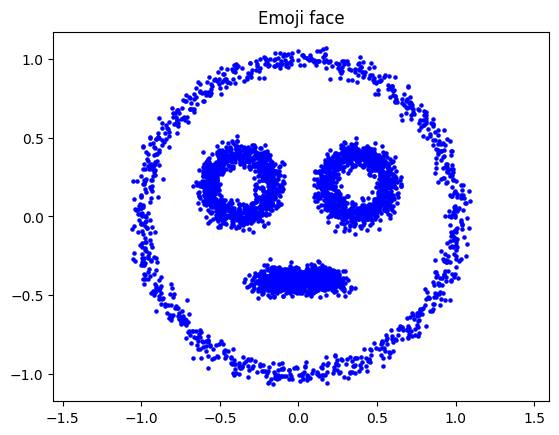

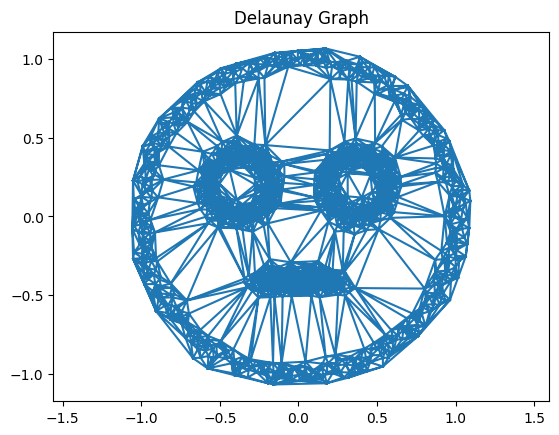

Threshold passed: 1.8


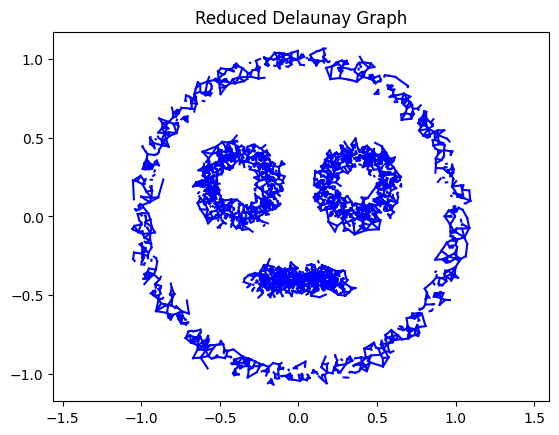

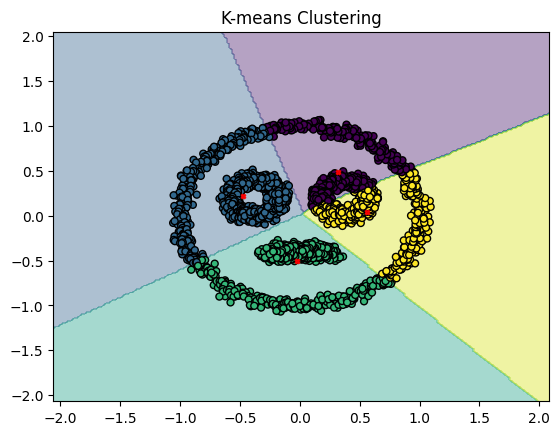

In [8]:
compute_rdg_vs_kmeans(face, threshold=1.8, num_cluster=4, title="Emoji face")